# InterSCity BikeScience

## Connecting datasets

### Input data

* From [Citybikes](https://www.citybik.es/) (public): data on bike stations at São Paulo city. We continuously collect the real time data available and store them in a historical way.
* From [Scipopulis](https://www.scipopulis.com/) (courtesy): socioeconomic data on the city, divided into several regions.
* From Prof. Luciano Costa (IFSC) and César Comin (UFSC) (courtesy): accessibility data on São Paulo bike stations.
* From [INMET](http://www.inmet.gov.br/portal/) (public): history of meteorological data on the city, measured every six hours by INMET stations.


### Objective

As a data preparation step, this notebook establish relationships between bike stations usage and other interesting data, such as socioeconomical, meteorological and accessibility.

### Python libraries

In [6]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets

import bikescience.input_data as input
import bikescience.geometry as geom
from bikescience.measure_time import determine_nearest_measure_times
import bikescience.filter_select as select

### Citybikes and Scipopulis data

Loading Scipopulis socioeconomic data. São Paulo city was divided into several small hexagonal regions, each one identified by its `hex_id`:

In [7]:
socioeconomic = input.load_socioeconomic()
socioeconomic.head(5)

total_loading  total_unloading  stops_len  trips_len  job_qty  \
hex_id                                                                  
28x318              0                0          0          0      0.0   
29x318              0                0          0          0      0.0   
29x319              0                0          0          0      0.0   
29x320              0                0          0          0      0.0   
29x321              0                0          0          0      0.0   

        population  education_qty  health_qty  0_2_salaries  2_3_salaries  \
hex_id                                                                      
28x318           6              0           0             1             0   
29x318          12              0           0             1             0   
29x319          12              0           0             3             0   
29x320           1              0           0             0             0   
29x321           0              0           0             0             0   

        3_5_salaries  5_10_salaries  above_10_salaries  
hex_id                                                  
28x318             0              0                  0  
29x318             0              0                  0  
29x319             0              0                  0  
29x320             0              0                  0  
29x321             0              0                  0

Loading Scipopulis geographic data. Each hexagon is defined by latitude and longitude of its vertices:

In [8]:
hexagons = input.load_hexagons()
print('Sample hexagon geographic data:')
hexagons[0]

Sample hexagon geographic data:


{'geometry': {'coordinates': [[[-46.82380420276044, -23.409699647772754],
    [-46.82441791036262, -23.408726104921346],
    [-46.825645325566974, -23.408726104921346],
    [-46.82625903316915, -23.409699647772754],
    [-46.825645325566974, -23.410673190624163],
    [-46.82441791036262, -23.410673190624163],
    [-46.82380420276044, -23.409699647772754]]],
  'type': 'Polygon'},
 'properties': {'hex_id': '28x318'},
 'type': 'Feature'}

From Citybikes database, we pick the bike stations from *Ciclosampa* and *Bikesampa* networks:

In [9]:
bikestations = input.load_bikestations(['ciclosampa', 'bikesampa'])
print(len(bikestations), 'stations')

135 stations


In [first notebook](/notebooks/01-map-visualization.ipynb) we have established a relation between these two databases by determining the hexagon (geographical region of Scipopulis) that corresponds to each bike station in Citybikes. The results were saved in JSON format so that a map web application can easily access them. Now, we want to have that same results in a Pandas Dataframe format for access from standard Python libraries such as Scikit-learn.

Matching regions and bike stations (may take a while). The `station_id` field will be used to match bike stations with the historical data previously collected:

In [10]:
geographical = geom.match_stations_and_hexagons(bikestations, hexagons)
geographical.to_csv('data/output/stations_hexagons.csv', index=False)
geographical.head(5)

station_id                station_name   hex_id
0  f783d903f92a164bd3a6db3f4c32a333  Estação Praça Panamericana   92x243
1  e8bf71e2c22c04b77a244bf10cc57d00            Estação Campinas  118x234
2  17bd0aa2c441688fa27f293f6edadacb              Estação Brasil  112x235
3  aa15e9fac0391976920464cf24e5fa9f             Estação Berrini   99x218
4  d18218272b29e66a67322d945bb6aee0     Estação Helio Pelegrino  109x222

In [11]:
# Have you already made this before?
geographical = pd.read_csv('data/output/stations_hexagons.csv')
geographical.head(5)

station_id                station_name   hex_id
0  f783d903f92a164bd3a6db3f4c32a333  Estação Praça Panamericana   92x243
1  e8bf71e2c22c04b77a244bf10cc57d00            Estação Campinas  118x234
2  17bd0aa2c441688fa27f293f6edadacb              Estação Brasil  112x235
3  aa15e9fac0391976920464cf24e5fa9f             Estação Berrini   99x218
4  d18218272b29e66a67322d945bb6aee0     Estação Helio Pelegrino  109x222

### Usage metric on bike stations

Since May 26, 2018, every five minutes a feeder program accesses Citybikes and stores the state of some bike stations in a MongoDB database. At each instant, we have how many `free_bikes` and `empty_slots` the stations have.

In [previous notebook](/notebooks/02-bike-stations-history.ipynb) the historical data was preprocessed to rank the bike stations by usage, according to a usage metric:

In [12]:
station_usage = input.load_station_usage()
station_usage.head(5)

id                           name  \
0  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   
1  02940bf056c740f6a5631da6dfa0e936             114 - Rua Alvorada   
2  0394a00c1c86470a59286c4389fd07f4                   62 - Equador   
3  0550eb4a3fe8ad2b4a47bcd87fa2c38a   238 - Avenida dos Semaneiros   
4  060b7bd093ab6900379d311100e6c0d7             201 - Metro Sumaré   

   general_daily_increase  weekend_and_holidays_daily_increase  \
0                2.988235                             2.777778   
1               13.141176                             8.000000   
2                3.035294                             4.148148   
3               17.705882                            15.370370   
4               14.047059                            16.000000   

   work_days_daily_increase  
0                  3.086207  
1                 15.534483  
2                  2.517241  
3                 18.793103  
4                 13.137931

Also, the per-hour variation of `free_bikes` variable was calculated:

In [13]:
usage_variation = input.load_usage_variation()
usage_variation.head(5)

id                           name  \
0  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   
1  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   
2  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   
3  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   
4  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   

             per_hour  free_bikes_increase  free_bikes_decrease  
0 2018-05-26 14:00:00                    0                    0  
1 2018-05-26 15:00:00                    0                    3  
2 2018-05-26 16:00:00                    1                    1  
3 2018-05-26 17:00:00                    0                    1  
4 2018-05-26 18:00:00                    0                    0

### Bike stations accessibility

Prof. Luciano Costa (IFSC) and César Comin (UFSC) developed an algorithm that calculates how easy is to arrive to a station from other near station (`in_accessibility`) and to go to another near station from that (`out_accessibility`). 

In [14]:
station_accessibility = input.load_accessibility(geographical)
station_accessibility.head(5)

station_id                   name  in_accessibility  \
0  acb732cd5739a3bf5962c3fe35f41e1f    1 - Largo da Batata         36.982986   
1  6cc99e8262b312cb73fd462d4fb21a6d     3 - CPTM Pinheiros         16.703455   
2  8437798d91a3747c0e02cfe649a4da64  4 - Rua Diogo Moreira         17.623630   
3  9a32d211abcc62fc2f5814f111efd43f        5 - Rua Butantã         21.675741   
4  7e71cbd6788d58aaedd61c0881887546        6 - Rua Manduri         14.414304   

   out_accessibility  
0          36.983983  
1          40.685006  
2          22.201417  
3          36.530369  
4          19.783618

### Historic meteorological data from São Paulo city

Unfortunately, INMET website doesn't offer an official API. One must log in and download the data manually.

* *Station:* SAO PAULO MIR de SANTANA  - SP (OMM: 83781)
* *Latitude:* -23.5
* *Longitude:* -46.61
* *Altitude:* 792.06m
* Operating since Dec 1st, 1945
* Requested data coverage: 05/26/2018 to 08/01/2018
* Times in UTC format

Some comments:

* *Temperature:* basic temperature is measured by [dry-bulb](https://en.wikipedia.org/wiki/Dry-bulb_temperature) method. The [wet-bulb](https://en.wikipedia.org/wiki/Wet-bulb_temperature) temperature is an air humidity indicator.
* *Wind direction* is given by [a code](http://www.inmet.gov.br/projetos/rede/pesquisa/form_mapas_c_horario.php) (requires an INMET account).

In [15]:
weather = input.load_weather()
weather.head(5)

Date  Time  DryBulbTemperature  WetBulbTemperature  RelativeHumidity  \
0  26/05/2018     0                17.4                15.7                84   
1  26/05/2018  1200                16.4                15.0                85   
2  26/05/2018  1800                22.2                16.7                57   
3  27/05/2018     0                17.2                15.4                83   
4  27/05/2018  1200                16.0                14.7                86   

   AtmosphericPressure  WindDirection  WindSpeed  Cloudiness  
0                931.1             18        2.5        10.0  
1                931.8              5        2.5        10.0  
2                930.0             23        2.1         6.0  
3                930.4             14        2.5        10.0  
4                933.4              9        2.5        10.0

### Matching station usage and weather measure times

Since usage data were gathered every five minutes, while weather measures were made three times a day (at 00:00 AM, 12:00 PM and 06:00 PM), it is necessary to determine the nearest weather measure time corresponding to each traffic instant. 

It will take some time, so if you preffer to load a previously saved result, go ahead!

In [ ]:
t0 = time.clock()

determine_nearest_measure_times(usage_variation)

t1 = time.clock()
print(t1 - t0, 'seconds elapsed')

usage_variation.to_csv('data/output/usage_weather.csv', index=False)
usage_variation.head(5)

In [16]:
# Did you already made this?
usage_variation = pd.read_csv('data/output/usage_weather.csv', parse_dates=['per_hour'])
usage_variation.head(5)

id                           name  \
0  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   
1  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   
2  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   
3  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   
4  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   

             per_hour  free_bikes_increase  free_bikes_decrease        Date  \
0 2018-05-26 14:00:00                    0                    0  26/05/2018   
1 2018-05-26 15:00:00                    0                    3  26/05/2018   
2 2018-05-26 16:00:00                    1                    1  26/05/2018   
3 2018-05-26 17:00:00                    0                    1  26/05/2018   
4 2018-05-26 18:00:00                    0                    0  26/05/2018   

   Time  
0  1200  
1  1800  
2  1800  
3  1800  
4  1800

### Displaying possible correlations

So far we have the following datasets:

* `usage_variation`: per-hour summarized bike stations usage
* `station_usage`: a metric that measures and ranks the stations use
* `socioeconomic`: socioeconomical data on several São Paulo regions
* `geographical`: relationship between bike stations and their corresponding Scipopulis socioeconomical regions
* `station_accessibility`: accessibility data on stations
* `weather`: historic of São Paulo meteorological data

#### A plotting function

Defining a function which, given a dataset, a main metric and a set of variable columns, displays a scatterplot between the main metric and each column:

In [17]:
def correlation_finder_plot(dataset, main_metric, columns):
    for col in columns:
        plt.figure(figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
        sns.scatterplot(dataset[col], dataset[main_metric])
        plt.show()

#### Correlation between station general usage and socioeconomical indicators

First, considering only the socioeconomical hexagon where each station is:

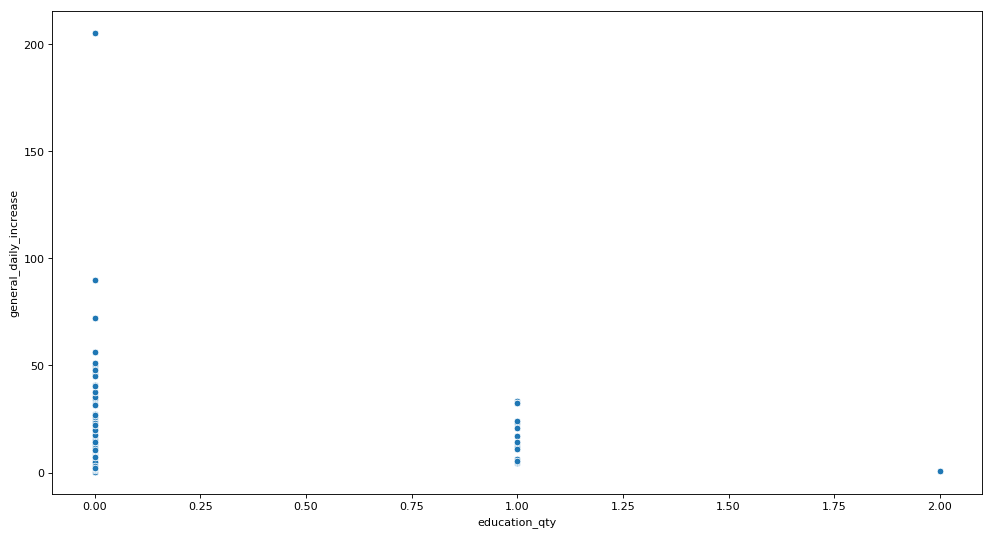

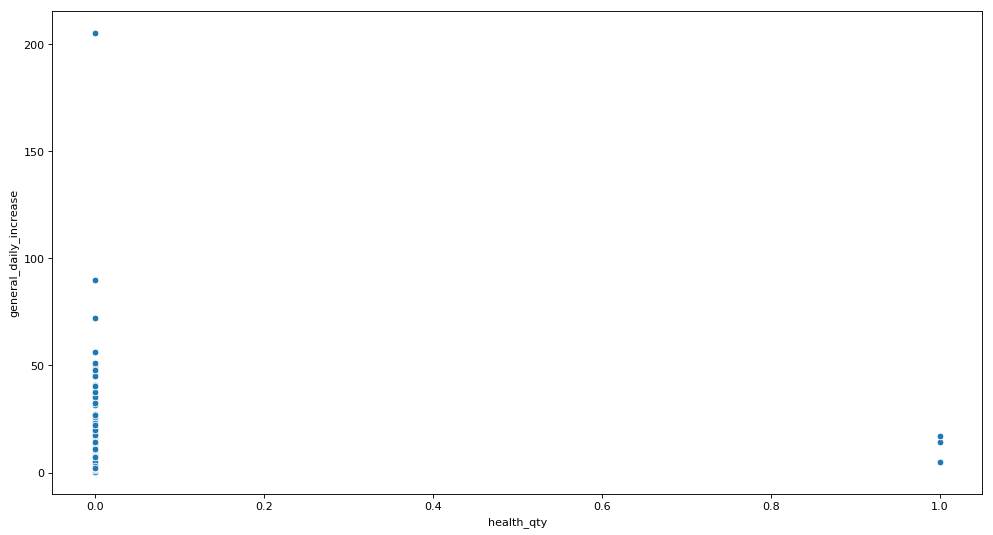

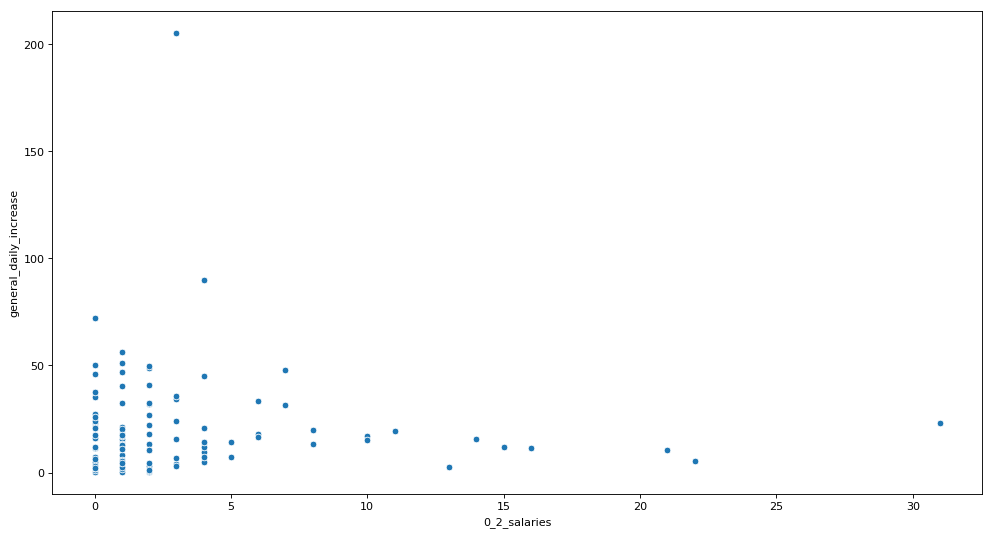

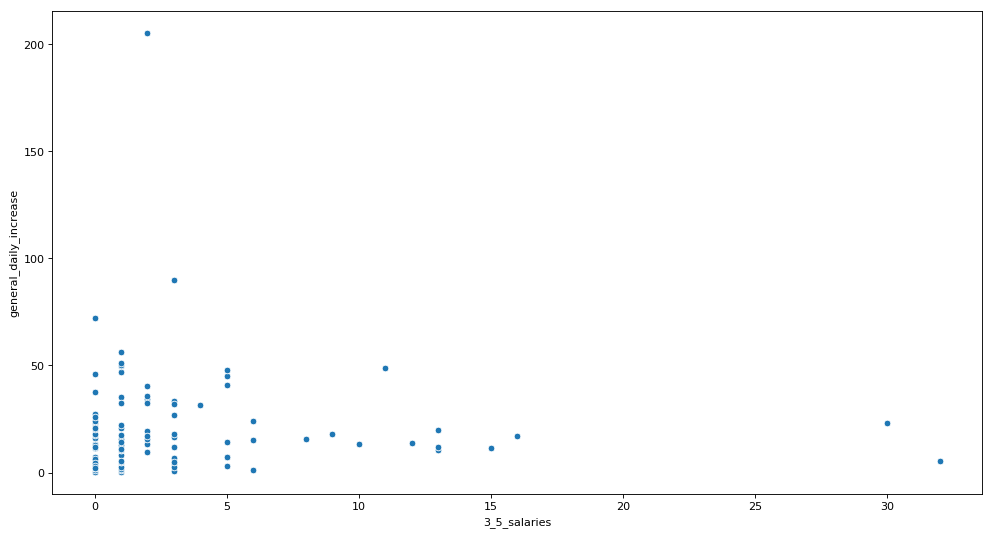

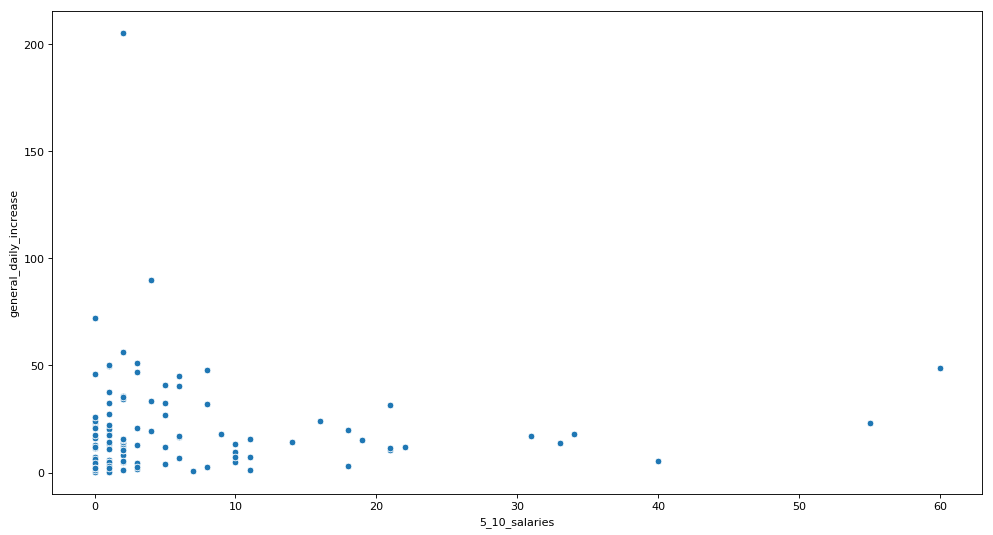

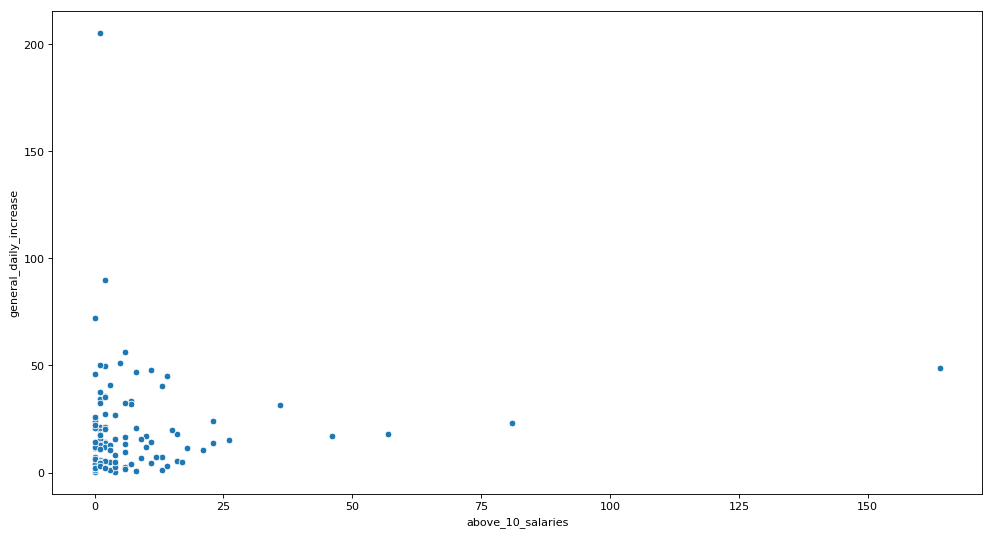

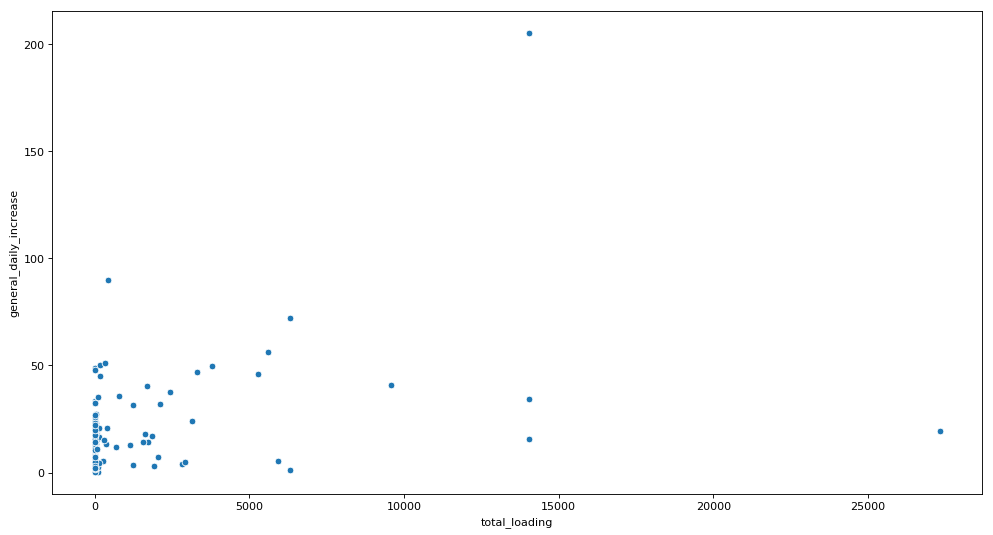

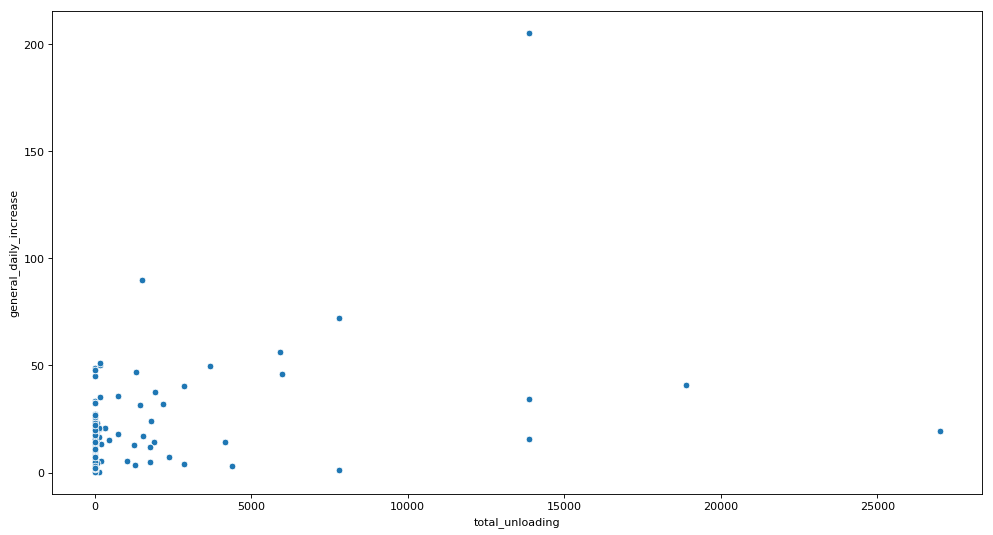

In [18]:
merge = station_usage.merge(geographical, left_on='id', right_on='station_id', how='inner').merge(
        socioeconomic, on='hex_id', how='inner')
correlation_finder_plot(merge, 'general_daily_increase', ['job_qty', 'population', 'education_qty', 'health_qty', 
        '0_2_salaries', '2_3_salaries', '3_5_salaries', '5_10_salaries', 'above_10_salaries',
        'total_loading', 'total_unloading', 'stops_len', 'trips_len'])

Now, also considering the adjacent hexagons. Our assumption is that bike trips are usually short.

**Update:** [notebook 10](10-Precalculating-neighborhood-indicators.ipynb) leaved the indicators precalculated for several neighborhood sizes.

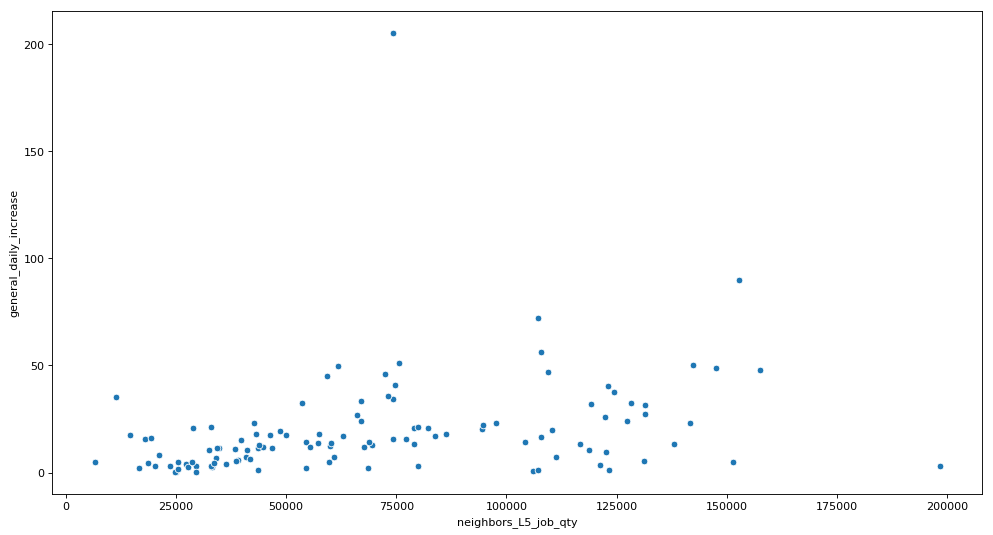

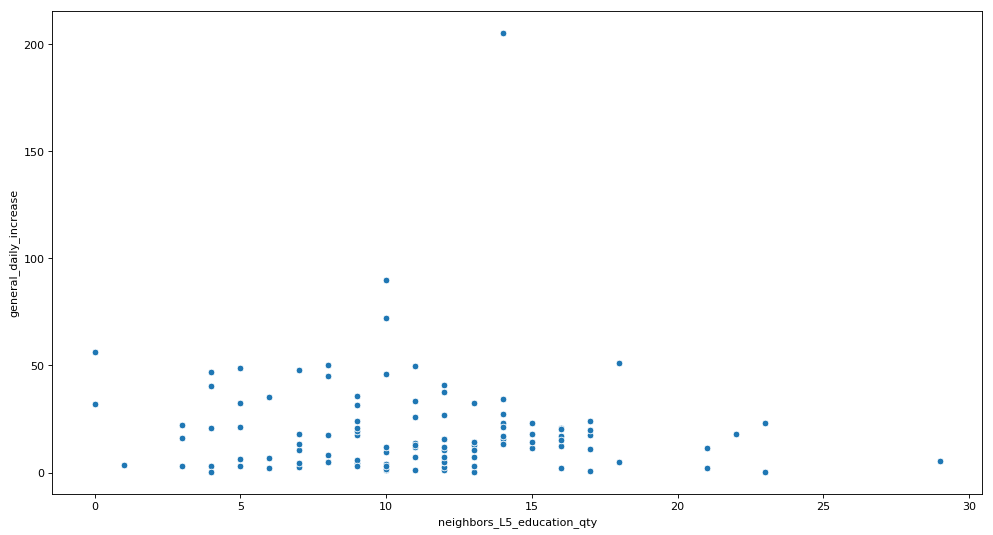

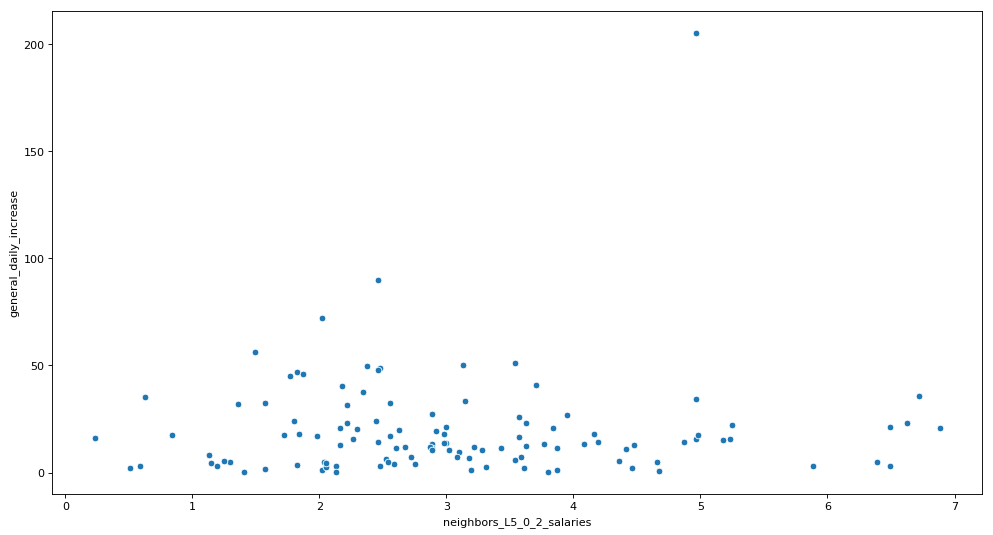

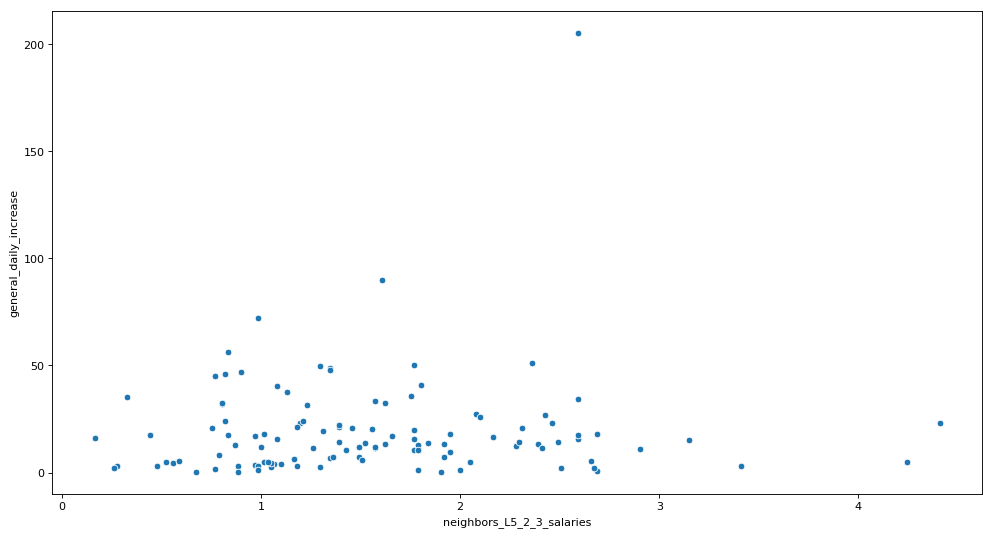

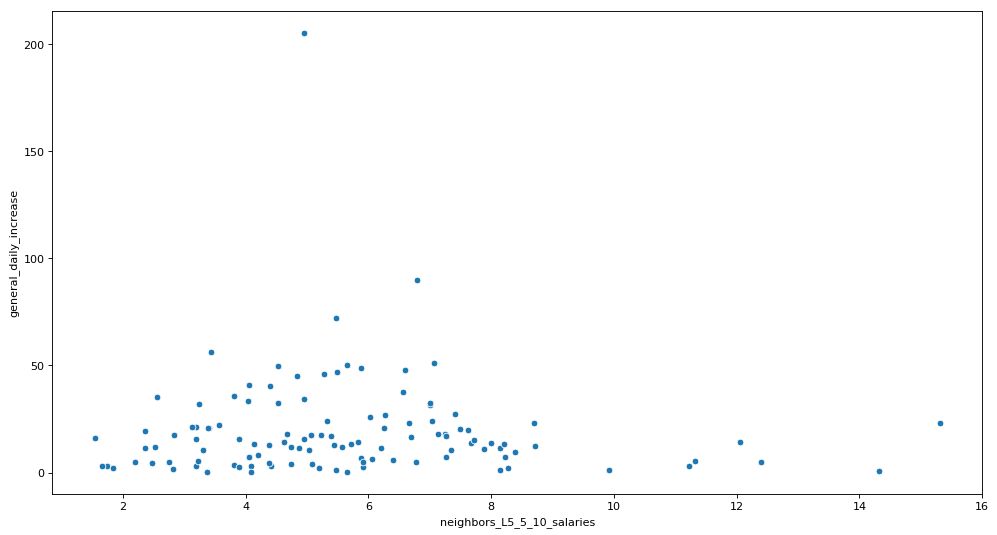

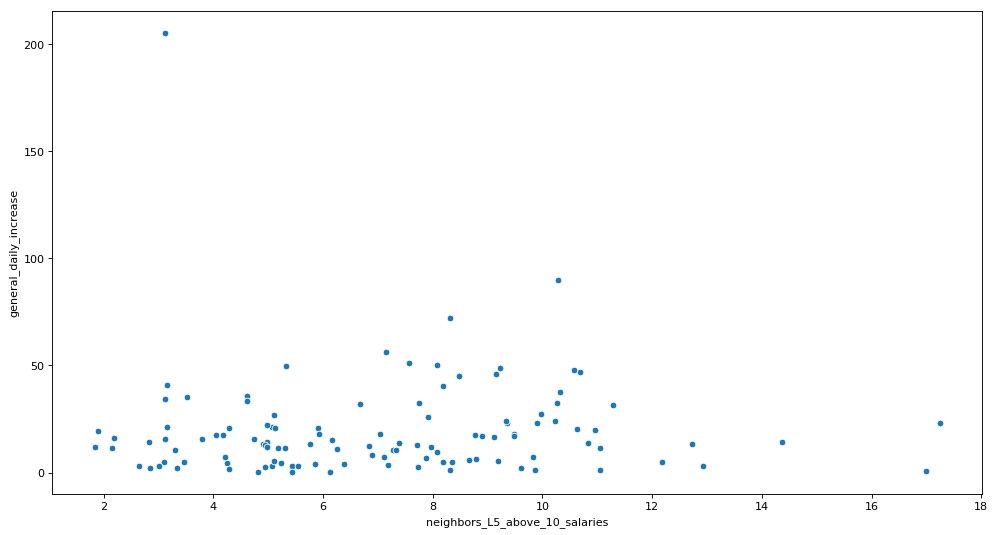

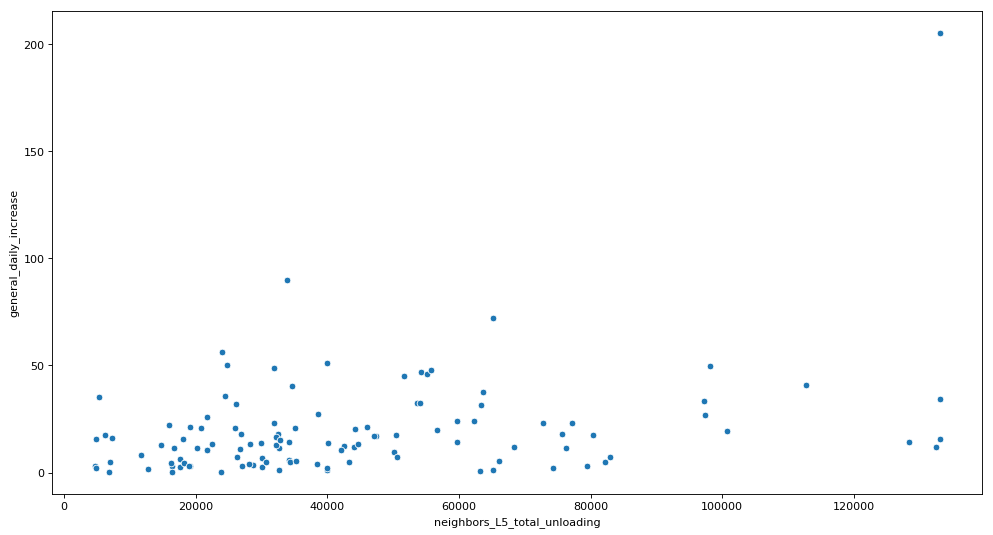

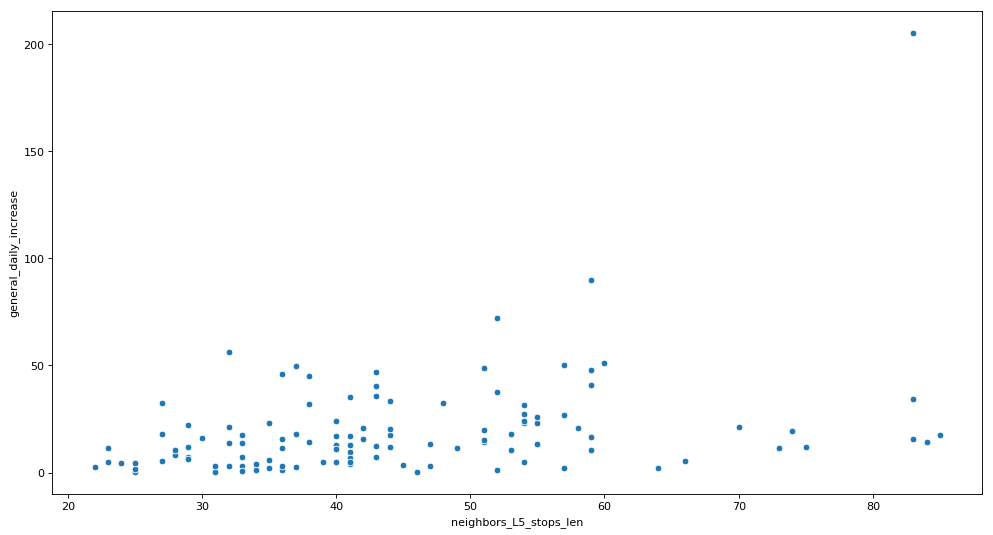

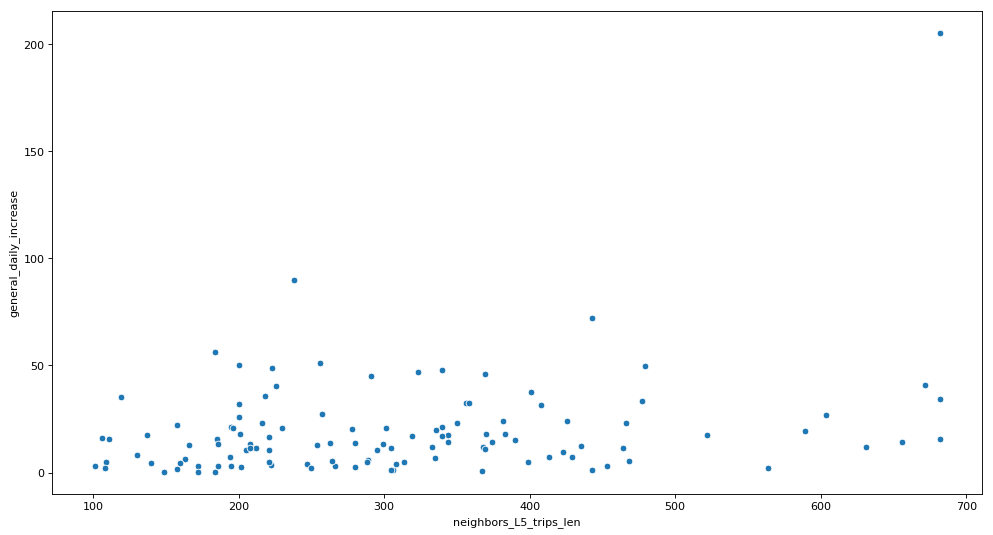

In [19]:
neighborhood = pd.read_csv('data/output/neighborhood_indicators.csv')
merge = station_usage.merge(geographical, left_on='id', right_on='station_id', how='inner') \
                     .merge(neighborhood, on='hex_id', how='inner')
correlation_finder_plot(merge, 'general_daily_increase', ['neighbors_L5_job_qty', 'neighbors_L5_population', 
        'neighbors_L5_education_qty', 'neighbors_L5_health_qty', 'neighbors_L5_0_2_salaries', 'neighbors_L5_2_3_salaries',
        'neighbors_L5_3_5_salaries', 'neighbors_L5_5_10_salaries', 'neighbors_L5_above_10_salaries',
        'neighbors_L5_total_loading', 'neighbors_L5_total_unloading', 'neighbors_L5_stops_len', 'neighbors_L5_trips_len'])

#### Correlation between stations general usage and its accessibility

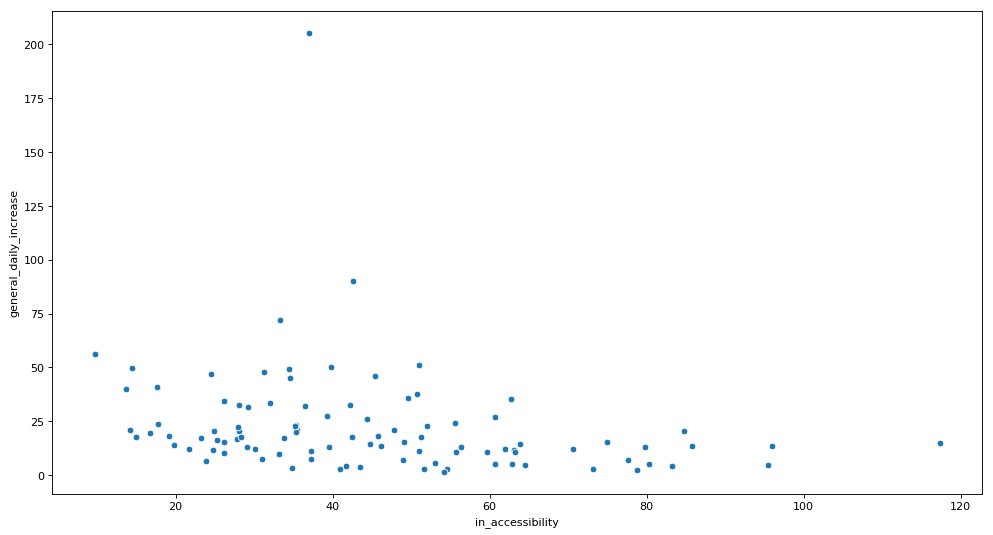

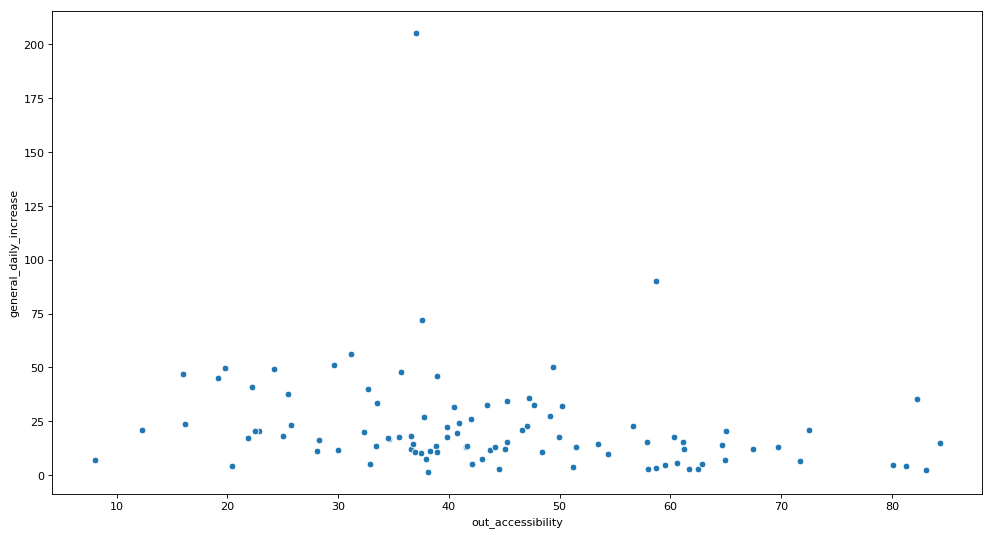

In [20]:
merge = station_usage.merge(station_accessibility, left_on='id', right_on='station_id', how='inner')
correlation_finder_plot(merge, 'general_daily_increase', ['in_accessibility', 'out_accessibility'])

#### Correlation between instant stations usage variation and weather conditions

Which weather conditions affect our station *per-hour* usage metric, i.e. `free_bikes_increase`?

In [21]:
samples = usage_variation

@interact(all_stations = widgets.Checkbox(value=True, description='All stations'),
          station=select.station_from_dataframe(geographical, 'station_name', 'station_id'))
def on_select(all_stations, station):
    samples = usage_variation
    if not all_stations:
        samples = samples[samples['id'] == station]
    merge = samples.merge(weather, on=['Date', 'Time'], how='inner')
    weather_fields = ['DryBulbTemperature', 'WetBulbTemperature', 'RelativeHumidity', 'AtmosphericPressure', 
                      'WindDirection', 'WindSpeed', 'Cloudiness']
    correlation_finder_plot(merge, 'free_bikes_increase', weather_fields)

interactive(children=(Checkbox(value=True, description='All stations'), Dropdown(description='station', options=(('Estação Praça Panamericana', 'f783d903f92a164bd3a6db3f4c32a333'), ('Estação Campinas', 'e8bf71e2c22c04b77a244bf10cc57d00'), ('Estação Brasil', '17bd0aa2c441688fa27f293f6edadacb'), ('Estação Berrini', 'aa15e9fac0391976920464cf24e5fa9f'), ('Estação Helio Pelegrino', 'd18218272b29e66a67322d945bb6aee0'), ('Estação Pedroso', 'd12c1c4d18b9dd925d27c82405bbffec'), ('Estação Cidade Jardim', '6d984b688ffc2b1a662eba08d4aebab4'), ('Estação Europa', '11edcdc74f826738908f3a61432f9e99'), ('Estação Teatro Renaissance', '774466d26209a6a0497db2c273999bc8'), ('Estação Pamplona', '17b7884d52c704aae95e9a73695d093f'), ('Estação Parque Vila Lobos', 'a8bb568eda668be2797f8cfff86a8685'), ('Estação Delfina', '6493c9b991c763bcdfd6e81710802b6a'), ('Estação Vila Olímpia', '5221ba46d62620a6a924e24a4ebcfeaa'), ('Estação Oscar Freire', '2a136c0f48ad634c262dbf8ec60e2ce3'), ('Estação Hcor', 'bd7b78cc60b86efd8cc452cf8def34bb'), ('Estação Itapeva', 'c64e456ca1dbec7b6e87747ec3d5e189'), ('Estação Parque Ibirapuera II', '279377798a8f6d4ad026fb518cbba9c3'), ('Estação inovaBra', 'b797b597f74af416394c720ae4897ed5'), ('105 - Praça João Duram Alonso', 'fedbe99c4519c675eb74ba1ecffb7f11'), ('201 - Metro Sumaré', '060b7bd093ab6900379d311100e6c0d7'), ('15 - Rua Prof. Artur Ramos', '9d077dc12eadaa528e5826b640fdbb97'), ('27 - Rua Min. Jesuíno Cardoso', 'd11f2a14cef28e32ae3ace3a90069534'), ('28 - Rua Comendador Miguel Calfat', '5952855ed553992e8f55e205dd8a150c'), ('80 - Praça Alexandre de Gusmão', 'df099096ebd238f9baa89f408d37a596'), ('68 - Praça Nicolau Scarpa', '2c75fd67d8fade3f07922aa448b07dd8'), ('26 - Praça Pierre Germayel', '8ffe929e3582680c54c4a986c6a26e65'), ('5 - Rua Butantã', '9a32d211abcc62fc2f5814f111efd43f'), ('11 - Praça Faria Lima', '477dfa927eb3a63d0caaa02865711d3b'), ('16 - Esporte Clube Pinheiros Boliche', '6640a44f3f8907b1a1dce4b95ea315f8'), ('22 - Rua Leopoldo Couto', 'd0dca73a8f08e1c509447f82de94e696'), ('23 - CPTM Vila Olímpia', '6f0ce1a3e4a933999494f860ab32ee62'), ('24 - Rua Funchal', 'e65375e75ba0ceeeeaa2d6622b505c1d'), ('25 - Rua Helena', '480de14d2dd32e279f626429595d0043'), ('234 - Praça Roquete Pinto', '55600b94d1c1775e085d9bea33f76a70'), ('50 - Rua Professor Carlos de Carvalho', '3ea16b6bbe57ca47b7ca92403940b3c5'), ('236 - Praça Ernami Braga', '0d7e10bba89bb1ee1d9ba77986f18e5b'), ('69 - Oscar Freire', '5ad1ce3fb9bacee063f777c040b68016'), ('230 - Rua Mariano Correia', 'fb5c988eb883e94001ef4ec9f98e0c01'), ('217 - Alameda Gabriel', 'e9e8038b1fc9cfe753a79498fb387843'), ('55 - Jacupiranga', 'b69552fa568cd22ac9e14ce92e55e5f1'), ('6 - Rua Manduri', '7e71cbd6788d58aaedd61c0881887546'), ('51 - Praça Luiz Delben Junior', 'c7365859b27647128effd0e328b82a25'), ('107 - Rua Indiana', '6785c43c06074593045610cf64ae08ad'), ('116 - Praça Dr. Francisco Patti', '33ff9617bb0d404c64168aa7c3dee391'), ('114 - Rua Alvorada', '02940bf056c740f6a5631da6dfa0e936'), ('64 - Maestro Elias Lobo', '66ac962b8bd2726fdedcbdbb1f052eff'), ('65 - Rua Dr. João Pinheiro', '2edab360f96f8c6db1c9d520b3dd28df'), ('34 - Rua Bastos Pereira', '24033c4f5277f387a29b718e110781f9'), ('95 - Metrô Brigadeiro', '69847324413dff0a13e0a6e069e66780'), ('131 - Pq. Ibirapuera Portão 06', '9aa8c3dffcf9f0c393d838aca5e5f38a'), ('1 - Largo da Batata', 'acb732cd5739a3bf5962c3fe35f41e1f'), ('3 - CPTM Pinheiros', '6cc99e8262b312cb73fd462d4fb21a6d'), ('7 - Praça Joaquim Roberto', 'a4fd2a81cbb2920eb354b4d2efd6b55b'), ('10 - Rua Campo Verde', '762596561a2c4afca64f4e5999dc53a3'), ('17 - Rua José Gonçalves de Oliveira', '75a2f4d8030c58515bf5754399a99e5e'), ('19 - Av. Dr. Cardoso de Melo', 'a64158898a8d749e13b35cd6d80f47cb'), ('29 - Rua João Franco', '5cc998f4dfae4dbdba43fc687ae613c0'), ('30 - Bandeira Paulista', 'da46d3d1b4d93b630dd7125a58e178b6'), ('35 - Rua Benedito Lapin', 'afd2073e9d39345084fb943deff8b40c'), ('36 - E.E. Aristides de Castro', 'ffadea46421981527554ee2448746dcd'), ('38 - Viradouro', 'df4f6511e